## The notebook for counting object instances per year and plotting the results on the line graph

The queries that can be answered using an adapted version of the following code include but are not limited to:
* Show count of *'Site'* per *'Provenance'* per *'Year'* in amphora date range;
* Show count of *'Provenances'* per *'Year'* in amphora date range;
* Show count of *'Provenances'* per *'Year'* per *'Site'* in amphora date range.

### 1. Import packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import regex as re
sns.set()
import sys
sys.path.append("../src")
from matplotlib.ticker import FormatStrFormatter
from functions import preprocess, year_object_count_df, plot_graph, get_Y_range

### 2. Load data into a pandas dataframe
With `usecols = []`  one specifies which columns from a csv file to load (optional)

In [2]:
df = pd.read_csv('SonataDataNewNew.csv', usecols = [
                                             'Amphora_type', 
                                             'Amphora_type_upper_date',
                                             'Amphora_type_lower_date', 
                                             'Site', 
                                             'Provenance'
                                             ]) 

### 3. Prepare data

#### 3.1 Check in which columns numeric values are of an object type
#### 3.2 If found, convert objects into numeric values (float) 
This is essential for performing math operations with these variables

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1707 entries, 0 to 1706
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Site                     1707 non-null   object
 1   Amphora_type             1707 non-null   object
 2   Provenance               1703 non-null   object
 3   Amphora_type_lower_date  1701 non-null   object
 4   Amphora_type_upper_date  1696 non-null   object
dtypes: object(5)
memory usage: 66.8+ KB


In [4]:
# Invalid parsing will be set as NaN
df['Amphora_type_upper_date'] = pd.to_numeric(df['Amphora_type_upper_date'], errors='coerce') 
df['Amphora_type_lower_date'] = pd.to_numeric(df['Amphora_type_lower_date'], errors='coerce') 

In [5]:
df.head()

,Site,Amphora_type,Provenance,Amphora_type_lower_date,Amphora_type_upper_date
0,Acqui Terme,Dr 6A,Adriatic Italy,-25.0,50.0
1,Acqui Terme,Dr 6B,Adriatic Italy,1.0,150.0
2,Acqui Terme,Dr 7-13,Baetica,-30.0,150.0
3,Acqui Terme,Haltern 70,Baetica,-80.0,192.0
4,Acqui Terme,Dr 2-4_5,Tyrrhenian Italy,-70.0,225.0


#### 3.3 Clean text data (from punctuation, double spaces) and lowercase
This is done in order to avoid inconsistency in object names, ets. Thus, to avoid errors while counting

In [3]:
df['Site'] = preprocess(df['Site'])
df['Provenance'] = preprocess(df['Provenance'])
df.head()

,Site,Amphora_type,Provenance,Amphora_type_lower_date,Amphora_type_upper_date
0,acqui terme,Dr 6A,adriatic italy,-25,50
1,acqui terme,Dr 6B,adriatic italy,1,150
2,acqui terme,Dr 7-13,baetica,-30,150
3,acqui terme,Haltern 70,baetica,-80,192
4,acqui terme,Dr 2-4_5,tyrrhenian italy,-70,225


#### 3.4 Filtering away certain values of data
If for any reason, any data with a specific value in a certain column should be excluded from the analysis, the following code syntax can be used:

`data = data[data['column_we_want_to_filter_by'] != 'value_it_should_not_have']`

`!=` means not equal to. This signifies that we take all rows of the dataframe which does not have the value specified.

In [5]:
df = df[df['Provenance'] != 'unknown'] 
#df = df[df['Site'] != 'unknown']  # no found
#df = df[df['Amphora_type'] != 'unknown'] # 3 found
df.head()

,Site,Amphora_type,Provenance,Amphora_type_lower_date,Amphora_type_upper_date
0,acqui terme,Dr 6A,adriatic italy,-25.0,50.0
1,acqui terme,Dr 6B,adriatic italy,1.0,150.0
2,acqui terme,Dr 7-13,baetica,-30.0,150.0
3,acqui terme,Haltern 70,baetica,-80.0,192.0
4,acqui terme,Dr 2-4_5,tyrrhenian italy,-70.0,225.0


### 4. Identify the list of (non unique for now) *'Sites'* per *'Amphora type'* per *'Provenance'*
To that end, one needs to specify the variables on the basis of which the data will be grouped
In the cell below, *'Sites'*  are grouped by *'Amphora type'*, *'Amphora start date'*, *'Amphora end date'* and *'Provenance'*

In [6]:
df_sites = df.groupby(['Amphora_type', 'Amphora_type_lower_date', 'Amphora_type_upper_date', 'Provenance'])['Site'].apply(lambda x: ','.join(x))
df_sites = df_sites.apply(lambda x: x.split(','))
df_sites = df_sites.reset_index()
df_sites = df_sites.rename(columns = {'Site':'List_of_sites'})
df_sites.head()

,Amphora_type,Amphora_type_lower_date,Amphora_type_upper_date,Provenance,List_of_sites
0,AC,1.0,200.0,aegean,"[terme di elogabalo, impianto fognario]"
1,AC1,1.0,350.0,aegean,"[boccone del povero, caere-pyrgi, cuma, tete ..."
2,AC1,1.0,350.0,crete,"[alba pompeia, verona]"
3,AC1/2,1.0,350.0,crete,[verona]
4,AC2,1.0,225.0,aegean,"[cuma, tete de cire, phase 4., gianicolo, os..."


### 5. Identify the list of (non unique for now) *'Provenances'* per *'Amphora type'*

In [7]:
df_prov = df.groupby(['Amphora_type', 'Amphora_type_lower_date', 'Amphora_type_upper_date', 'Site'])['Provenance'].apply(lambda x: ','.join(x))
df_prov = df_prov.apply(lambda x: x.split(','))
df_prov = df_prov.reset_index()
df_prov = df_prov.rename(columns = {'Provenance':'List_of_provenances'})
df_prov.head()

,Amphora_type,Amphora_type_lower_date,Amphora_type_upper_date,Site,List_of_provenances
0,AC,1.0,200.0,"terme di elogabalo, impianto fognario",[aegean]
1,AC1,1.0,350.0,alba pompeia,[crete]
2,AC1,1.0,350.0,boccone del povero,[aegean]
3,AC1,1.0,350.0,caere-pyrgi,[aegean]
4,AC1,1.0,350.0,"cuma, tete de cire, phase 4.",[aegean]


### 6. Count *'Sites'* per *'Provenance'* per *'Year'*
At this step, the list of unique *'Sites'* will be considered
With `df_sites[df_sites['Provenance'] == 'egypt']` one specifies the *'Provenance'* of interest


In [8]:
site_count_eqypt = year_object_count_df(data = df_sites[df_sites['Provenance'] == 'egypt'], 
                                        lower_date = 'Amphora_type_lower_date',  
                                        upper_date = 'Amphora_type_upper_date',
                                        object_list = 'List_of_sites')    

In [9]:
site_count_blacksea = year_object_count_df(data = df_sites[df_sites['Provenance'] == 'black sea'], 
                                           lower_date = 'Amphora_type_lower_date',
                                           upper_date = 'Amphora_type_upper_date',
                                           object_list = 'List_of_sites' )    

### 7. Count *'Provenances'* per *'Year'*

In [10]:
provenance_count = year_object_count_df(data = df_prov,  
                                        lower_date = 'Amphora_type_lower_date',  
                                        upper_date = 'Amphora_type_upper_date',
                                        object_list = 'List_of_provenances')  

### 8. Count *'Provenances'* per *'Year'* per *'Site'*
With `df_prov[df_prov[' '] == ' ']` one specifies the *'Site'* of interest

In [11]:
provenance_count_aquileia = year_object_count_df(data = df_prov[df_prov['Site'] == 'aquileia'],  
                                                 lower_date = 'Amphora_type_lower_date',  
                                                 upper_date = 'Amphora_type_upper_date',
                                                 object_list = 'List_of_provenances') 

### 9. Plot the graphs

#### 9.1 Create a dictionary for plotting
Now dictionaries containing the site and provenance count dataframes are made. The keys (what is incapsulated in '') are going to be the labels for the plot. The variables refered to, are the dataframes created just above.

In [12]:
dict_site_count = {'Egypt': site_count_eqypt, 'Black Sea': site_count_blacksea}
dict_prov_count = {'Provenances': provenance_count}
dict_prov_per_site = {'Aquileia': provenance_count_aquileia}

#### 9.2 Plot and save
Here the data from the previously created count data frames are plotted. 

This is done using the function `plotgraph()`. 

To change the colour of lines, pass a list of strings with colour names to `palette` argument. 

To change the default `'solid'` line, pass f.ex., `'dashed'` to `linestyle` argument.o not show 

To hide values on axis uncomment `ax.axes.xaxis.set_ticks([])` for X and `ax.axes.yaxis.set_ticks([])` for Y.

To plot a single line graph specify only 1 axes in this line `fig, ax = plt.subplots(figsize=(20, 11))` and use this `ax` variable as an input for `ax` argument in `plotgraph()`. 
To plot 2 and more graphs side by side:
1. specify that many axes as graphs and the respective number of rows/columns of the subplot grid. F.ex., to plot 2 lie=ne graphs `fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(20, 11))`
2. call `plot_graph()` on each `dictionary` and use the respective `ax` variable as an input for `ax` argument in `plotgraph()`.  
F.ex., in `plot_graph(dicts_of_df = provenance_count, palette=['green'], linestyle = 'dashed', ax = ax1)` the line graph for dic with provenances will be refered as `ax1` and placed on the **right** side of the graph.

**Note**: Remember to set labels, background colour, etc for both axes like in the example below.

#### 9.2.2 **Count of *'Site'* per *'Provenance'* per *'Year'* in amphora date range**

/tmp/ipykernel_38380/938200233.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(i) if i != 0 else 1 for i in ax.get_xticks()])


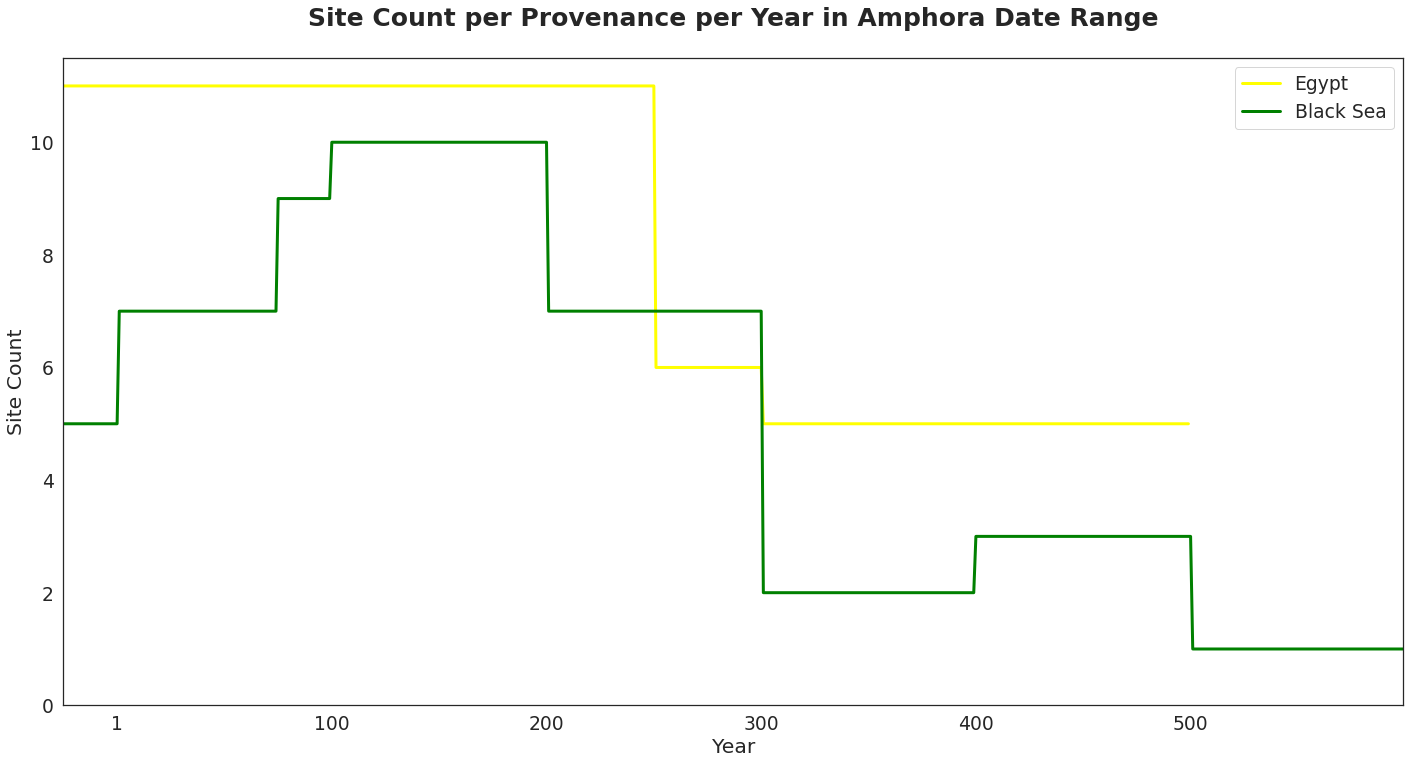

In [13]:
sns.set(font_scale=1.7)

#Remove squeres from background
sns.set_style(style='white')  

fig, ax = plt.subplots(figsize=(20, 11))

#Calculate minimum and maximum Y values to define the cuff off further
minimum, maximum = get_Y_range(dict_site_count)

plot_graph(dicts_of_df = dict_site_count,
           palette=['yellow', 'green'],  
           ax = ax)
           

# Cut off the range of Y value shown 
ax.set_xlim(minimum, maximum)

# Remove 0 from Y axis
ax.set_ylim(0, None)

#Change background colour
ax.set_facecolor("white")  

#Change Y values format 
# integers = '%.0f'
# decimals = '%.1f', the number before 'f' defines how many values to show after dot
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))  

ax.set_ylabel("Site Count")
ax.set_xlabel("Year")

#To hide values on axis
#ax.axes.xaxis.set_ticks([])
#ax.axes.yaxis.set_ticks([])

# Make sure that if 0 is included on the x-axis it is turned into 1 instead
ax.set_xticklabels([int(i) if i != 0 else 1 for i in ax.get_xticks()])

ax.set_title(label = 'Site Count per Provenance per Year in Amphora Date Range', size=25, y=1.04, fontweight='bold')
plt.tight_layout()



# Save the graph
plt.savefig('./site_count.pdf')

#### 9.2.3 **Count of *'Provenances'* per *'Year'* in amphora date range**

/tmp/ipykernel_38380/836438931.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(i) if i != 0 else 1 for i in ax.get_xticks()])


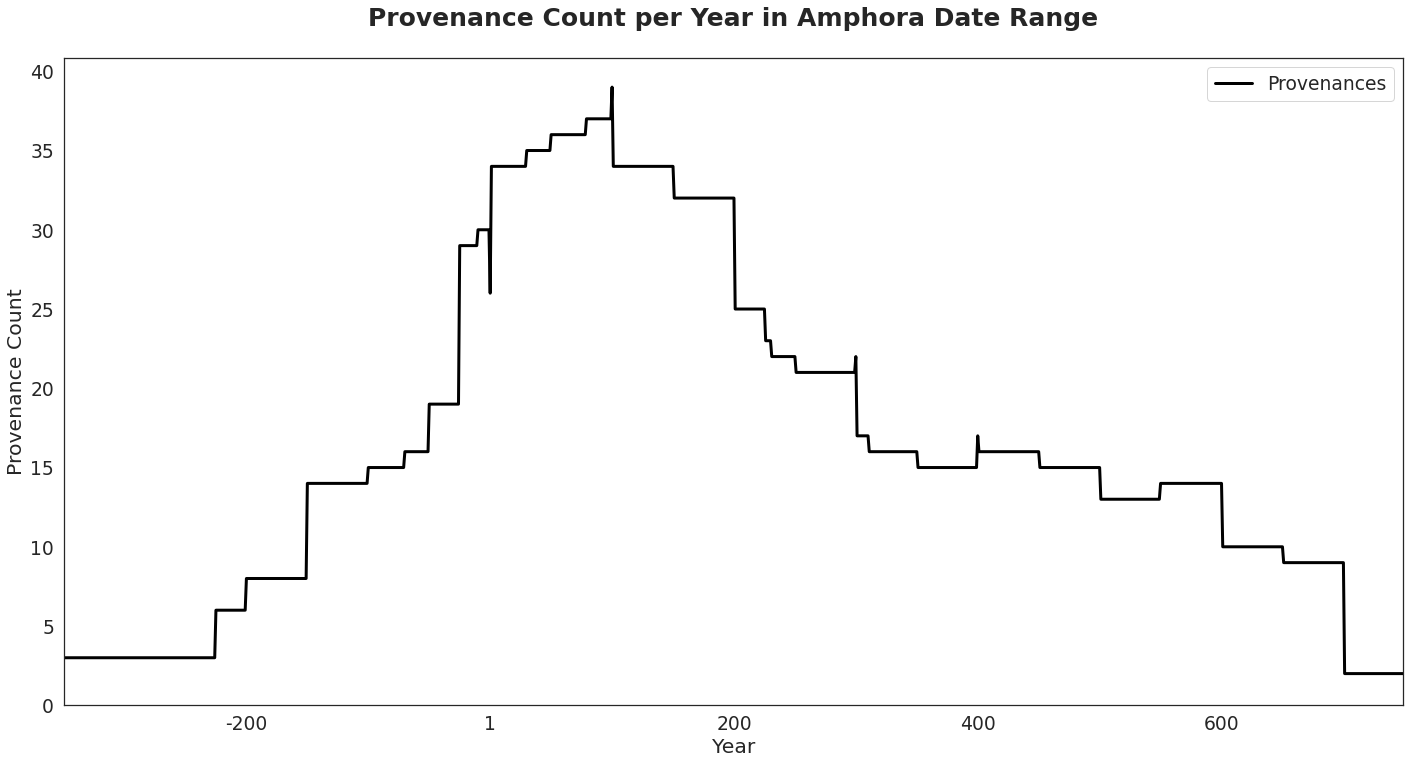

In [14]:
sns.set(font_scale=1.7)

#Remove squeres from background
sns.set_style(style='white')  

fig, ax = plt.subplots(figsize=(20, 11))

#Calculate minimum and maximum Y values to define the cuff off further
minimum, maximum = get_Y_range(dict_prov_count)

plot_graph(dicts_of_df = dict_prov_count,
           palette=['black'],  
           ax = ax)
           

# Cut off the range of Y value shown 
ax.set_xlim(minimum, maximum)

# Remove 0 from Y axis
ax.set_ylim(0, None)

#Change background colour
ax.set_facecolor("white")  

#Change Y values format 
# integers = '%.0f'
# decimals = '%.1f', the number before 'f' defines how many values to show after dot
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))  

ax.set_ylabel("Provenance Count")
ax.set_xlabel("Year")

#To hide values on axis
#ax.axes.xaxis.set_ticks([])
#ax.axes.yaxis.set_ticks([])

# Make sure that if 0 is included on the x-axis it is turned into 1 instead
ax.set_xticklabels([int(i) if i != 0 else 1 for i in ax.get_xticks()])

ax.set_title(label = 'Provenance Count per Year in Amphora Date Range', size=25, y=1.04, fontweight='bold')
plt.tight_layout()



# Save the graph
plt.savefig('./provenance_count.pdf')

#### 9.2.3 **Count of *'Provenances'* per *'Year'* per *'Site'* in amphora date range**

/tmp/ipykernel_38380/3761729856.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(i) if i != 0 else 1 for i in ax.get_xticks()])


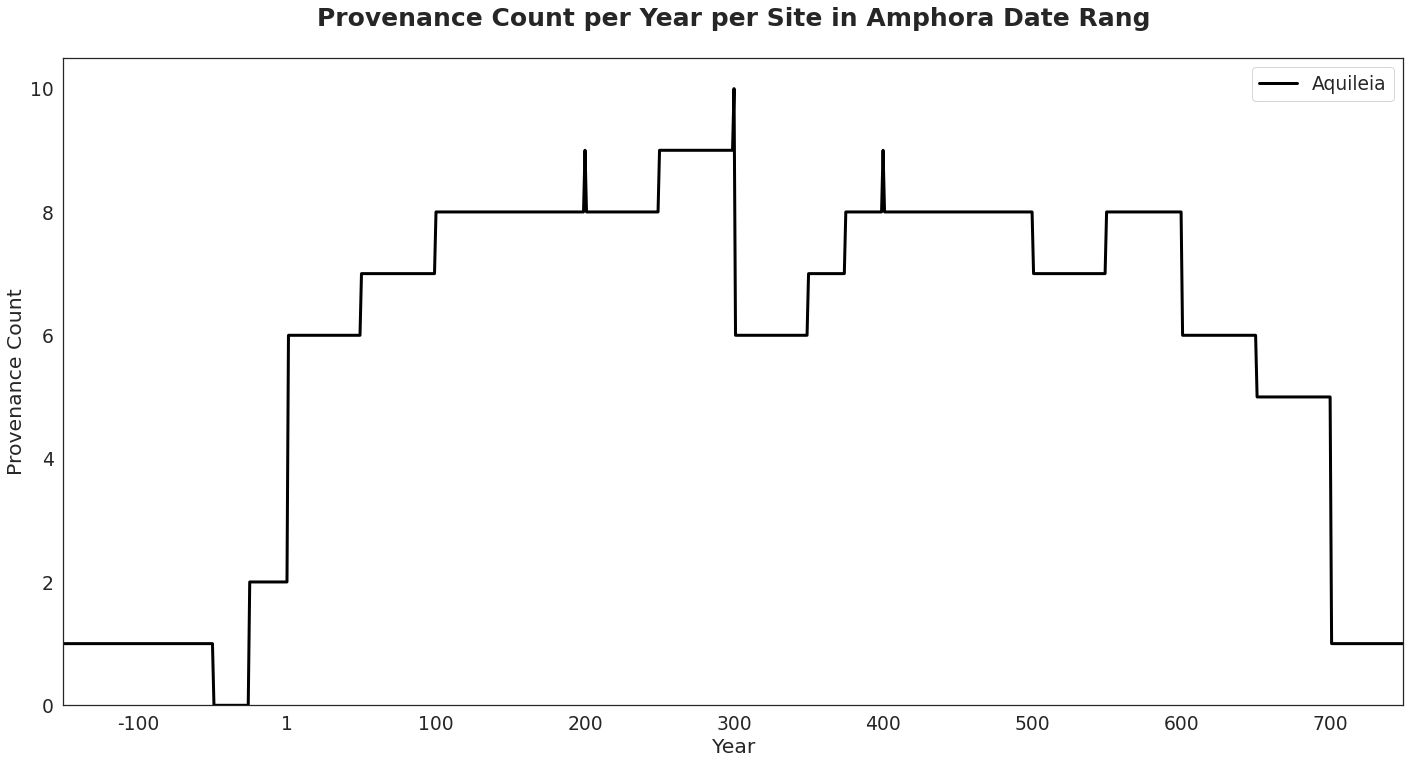

In [16]:
sns.set(font_scale=1.7)

#Remove squeres from background
sns.set_style(style='white')  

fig, ax = plt.subplots(figsize=(20, 11))

#Calculate minimum and maximum Y values to define the cuff off further
minimum, maximum = get_Y_range(dict_prov_per_site)

plot_graph(dicts_of_df = dict_prov_per_site,
           palette=['black'],  
           ax = ax)
           

# Cut off the range of Y value shown 
ax.set_xlim(minimum, maximum)

# Remove 0 from Y axis
ax.set_ylim(0, None)

#Change background colour
ax.set_facecolor("white")  

#Change Y values format 
# integers = '%.0f'
# decimals = '%.1f', the number before 'f' defines how many values to show after dot
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))  

ax.set_ylabel("Provenance Count")
ax.set_xlabel("Year")

#To hide values on axis
#ax.axes.xaxis.set_ticks([])
#ax.axes.yaxis.set_ticks([])

# Make sure that if 0 is included on the x-axis it is turned into 1 instead
ax.set_xticklabels([int(i) if i != 0 else 1 for i in ax.get_xticks()])

ax.set_title(label = 'Provenance Count per Year per Site in Amphora Date Rang', size=25, y=1.04, fontweight='bold')
plt.tight_layout()



# Save the graph
plt.savefig('./provenance_count.pdf')

/tmp/ipykernel_38380/4107366033.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([int(i) if i != 0 else 1 for i in ax1.get_xticks()])
/tmp/ipykernel_38380/4107366033.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([int(i) if i != 0 else 1 for i in ax2.get_xticks()])


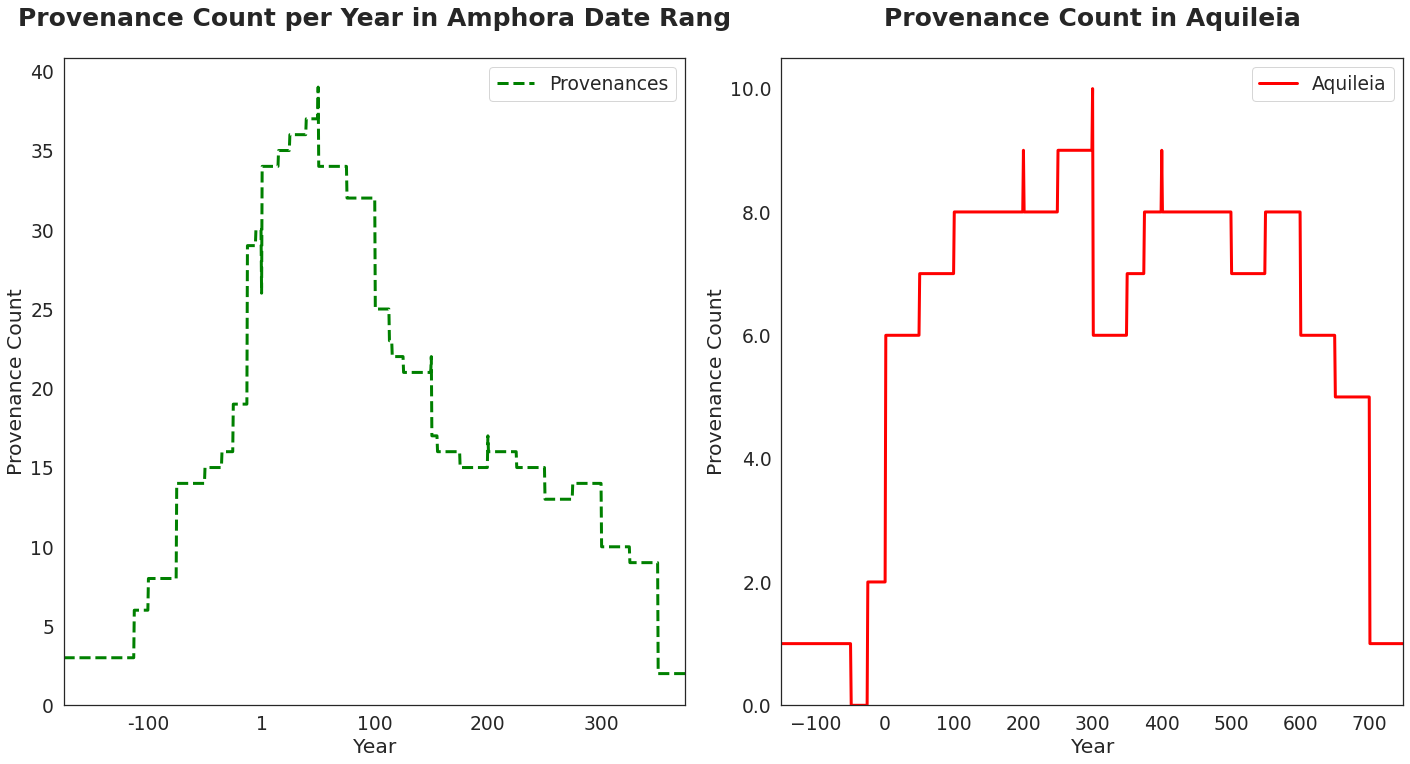

In [18]:
sns.set(font_scale=1.7)

#Remove squeres from background
sns.set_style(style='white')  

fig, (ax1, ax2)= plt.subplots(nrows=1, ncols=2, figsize=(20, 11))

#Calculate minimum and maximum Y values 
minimum1, maximum1 = get_Y_range(dict_prov_count)
minimum2, maximum2 = get_Y_range(dict_prov_per_site)

plot_graph(dicts_of_df = dict_prov_count,
           palette=['green'],
           linestyle = 'dashed',
           ax = ax1)
           

plot_graph(dicts_of_df = dict_prov_per_site,
            palette=['red'],
            linestyle = 'solid',
            ax = ax2)

# Cut off the range of Y value shown 
ax1.set_xlim(minimum1, maximum1)
ax2.set_xlim(minimum2, maximum2)

# Remove 0 from Y axis
ax1.set_ylim(0, None)
ax2.set_ylim(0, None)

#Change background colour
ax1.set_facecolor("white")  
ax2.set_facecolor("white")

#Change Y values format 
# integers = '%.0f'
# decimals = '%.1f', the number before 'f' defines how many values to show after dot
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))  
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax1.set_ylabel("Provenance Count")
ax1.set_xlabel("Year")

ax2.set_xlabel("Year")
ax2.set_ylabel("Provenance Count")


#To hide values on axis
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
#ax2.axes.xaxis.set_ticks([])
#ax2.axes.yaxis.set_ticks([])


# Make sure that if 0 is included on the x-axis it is turned into 1 instead
ax1.set_xticklabels([int(i) if i != 0 else 1 for i in ax1.get_xticks()])
ax1.set_title(label = 'Provenance Count per Year in Amphora Date Rang', size=25, y=1.04, fontweight='bold')

ax1.set_xticklabels([int(i) if i != 0 else 1 for i in ax2.get_xticks()])
ax2.set_title(label = 'Provenance Count in Aquileia', size=25, y=1.04, fontweight='bold')
plt.tight_layout()


# Save the graph
plt.savefig('./site_count.pdf')